<a href="https://colab.research.google.com/github/hhaemin/computer_vision/blob/main/Harris_corner_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://docs.opencv.org/4.x/dc/d0d/tutorial_py_features_harris.html

## Goal
In this chapter,

We will understand the concepts behind Harris Corner Detection.

We will see the following functions: cv.cornerHarris(), cv.cornerSubPix()

##Harris Corner Detector in OpenCV

OpenCV has the function cv.cornerHarris() for this purpose. Its arguments are:

- img - Input image. It should be grayscale and float32 type.
- blockSize - It is the size of neighbourhood considered for corner detection
- ksize - Aperture parameter of the Sobel derivative used.
- k - Harris detector free parameter in the equation.

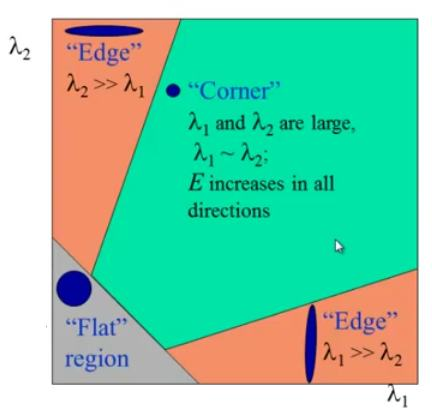

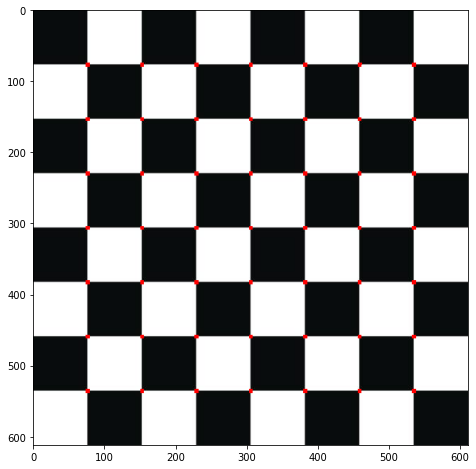

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

filename = 'chessboard.jpg'
img = cv.imread(filename)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv.cornerHarris(gray, 2, 3, 0.04)

#result is dilated for marking the corners, not important
dst = cv.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

plt.figure(figsize=(15,8))
plt.imshow(img[:,:,::-1])
plt.show()

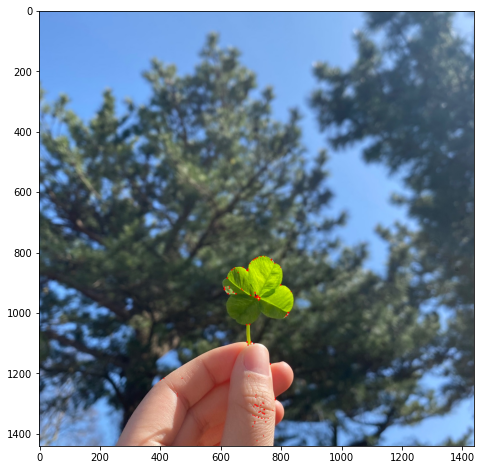

In [3]:
## run your own image !
filename = 'image.jpeg'
img = cv.imread(filename)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv.cornerHarris(gray, 2, 3, 0.04)

#result is dilated for marking the corners, not important
dst = cv.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

plt.figure(figsize=(15,8))
plt.imshow(img[:,:,::-1])
plt.show()

## Using Kornia library

https://kornia.readthedocs.io/en/latest/_modules/kornia/feature/responses.html

In [5]:
!pip install kornia
!pip install kornia[x]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 551 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 148 kB 5.3 MB/s 


torch.Size([1, 1, 612, 612])


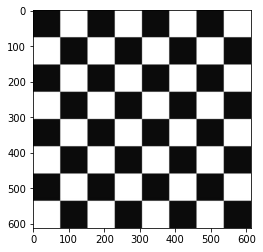

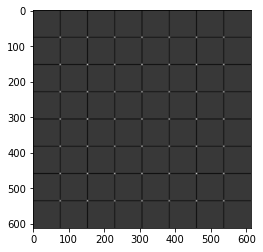

In [6]:
import torch
from torchvision import transforms
import kornia.feature as KF

from PIL import Image

filename = 'chessboard.jpg'

tensor = transforms.ToTensor()(Image.open(filename).convert('L')).unsqueeze(0)

print(tensor.shape)

plt.imshow(tensor.squeeze(), cmap='gray')
plt.show()

harris = KF.responses.CornerHarris(0.05) 

cornerness = harris(tensor)

plt.imshow(cornerness.squeeze(), cmap='gray')
plt.show()



## (심화) Example on the scale pyramid

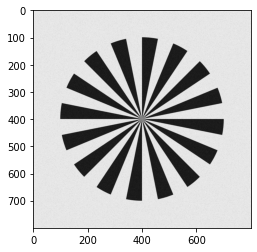

In [7]:
import kornia
import kornia.geometry as KG
from kornia import tensor_to_image as tti

## ScalePyramid create spyramid of blurred and downsamples images
SP = KG.ScalePyramid(3, 1.0, 10)

filename = 'siemens.png' # # filename = 'image.jpeg'

img = Image.open(filename)#.convert('L')

timg = kornia.utils.image_to_tensor(np.array(img), keepdim=False).float() / 255.  / 255.  #This specific image somehow has [0, 255**2] range

plt.imshow(kornia.utils.tensor_to_image(timg[0]), 'gray')

7 torch.Size([1, 1, 6, 800, 800])


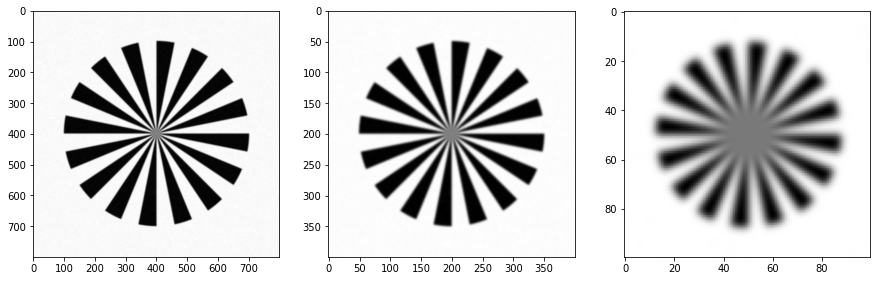

In [8]:
resp = KF.responses.CornerHarris(0.05) 

SP = KG.ScalePyramid(3, 1.6, 10)

pyr, sigmas, scales = SP (timg)
print (len(pyr), pyr[0].shape)

fig, axes = plt.subplots(1,3, figsize=(15,8))

ax = axes[0]
ax.imshow(tti(pyr[0][0,0,0]), 'gray')
ax = axes[1]
ax.imshow(tti(pyr[1][0,0,0]), 'gray')
ax = axes[2]
ax.imshow(tti(pyr[3][0,0,0]), 'gray')
current_level = pyr[1]

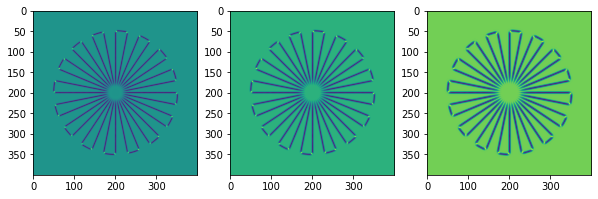

In [9]:

fig, axes = plt.subplots(1,3, figsize=(10,6))

cornerness = resp(current_level[0])
for i in range(3):
    ax = axes[i]
    ax.imshow(tti(cornerness[0,i]))


In [10]:
## The next component is detector of the maximum of the local responce: ConvQuadInterp3d(), 
## which does quadratic interpolation of the location, or ConvSoftArgmax3d, 
## which does softargmax estimation of the location.

nms1 = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3), # nms windows size (scale, height, width)
                                       stride=(1,1,1), # stride (scale, height, width)
                                       padding=(1, 1, 1),
                                       temperature=0.1) # nms windows size (scale, height, width)

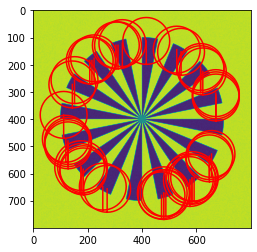

torch.Size([1, 40, 2, 3])


In [11]:
def visualize_LAF(img, LAF, img_idx = 0):
    x, y = kornia.feature.laf.get_laf_pts_to_draw(LAF, img_idx)
    plt.figure()
    plt.imshow(kornia.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, 'r')
    plt.show()
    return

#Lets detect Harris corners
n_feats = 40
mr_size = 6.0 

harris_local_detector = KF.ScaleSpaceDetector(n_feats, 
                                    resp_module=resp,
                                    nms_module=nms1,
                                    mr_size=mr_size)

lafs, resps = harris_local_detector(timg)

visualize_LAF(timg, lafs)
print(lafs.shape)

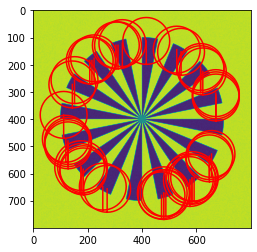

torch.Size([1, 40, 2, 3])


In [12]:
#n_feats = 40
mr_size = 6.0 
nms1 = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3), # nms windows size (scale, height, width)
                                       stride=(1,1,1), # stride (scale, height, width)
                                       padding=(1, 1, 1),
                                       temperature=0.1,
                                       strict_maxima_bonus=100.) # nms windows size (scale, height, width)

harris_local_detector = KF.ScaleSpaceDetector(n_feats, 
                                    resp_module=resp,
                                    nms_module=nms1,
                                    mr_size=mr_size)

lafs, resps = harris_local_detector(timg)
visualize_LAF(timg, lafs)
print(lafs.shape)

생각보다 duplication 제거가 잘 안된다.

따라서, quadrative interpolation 3D 를 통해 subpixel 수준에서의 non-maximal suppression을 한 번 더 수행한다.

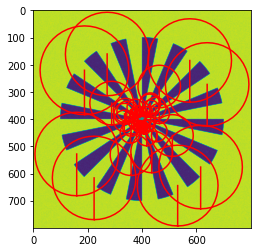

In [13]:
#Lets detect Harris corners w/o duplicates
n_feats = 50
mr_size = 6.0 
nms = kornia.geometry.ConvQuadInterp3d(10, 2e-4) 

harris_local_detector = KF.ScaleSpaceDetector(n_feats, 
                                    resp_module=resp,
                                    nms_module=nms,
                                    mr_size=mr_size)

lafs, resps = harris_local_detector(timg)
visualize_LAF(timg,lafs)

Harris 가 아니라 다른 affine 모듈 (e.g., DoG 나 LoG를 사용)은 어떻게 될까? 

scale-space detector에 shape estimator를 넣어서 실행.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `LAFAffineShapeEstimator` default behaviour is changed and now it does preserve original LAF orientation. Make sure your code accounts for this.
  


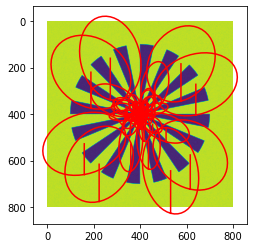

In [14]:
# What about Harris-Affine features?
harris_affine_local_detector = KF.ScaleSpaceDetector(n_feats, 
                                    resp_module=kornia.feature.CornerHarris(0.05),
                                    nms_module=nms,
                                    mr_size=mr_size,
                                    aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),
                                    minima_are_also_good=False)
lafs, resps = harris_affine_local_detector(timg)
visualize_LAF(timg,lafs)

Feature orientation estimator 도 추가 가능

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `LAFAffineShapeEstimator` default behaviour is changed and now it does preserve original LAF orientation. Make sure your code accounts for this.
  


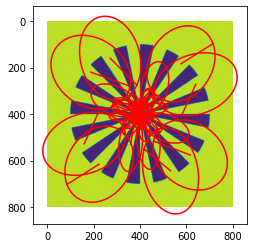

In [15]:
# Now lets also detect feature orientation
harris_affine_local_detector = KF.ScaleSpaceDetector(n_feats, 
                                    resp_module=kornia.feature.CornerHarris(0.05),
                                    nms_module=nms,
                                    mr_size=mr_size,
                                    aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),
                                    ori_module=kornia.feature.LAFOrienter(patch_size=19))

lafs, resps = harris_affine_local_detector(timg)
visualize_LAF(timg,lafs)

## Obtain patch descriptor using the obtained affine regions

In [16]:
#Lets describe patches with SIFT descriptor
descriptor = KF.SIFTDescriptor(32)

patches =  kornia.feature.extract_patches_from_pyramid(timg, lafs)
B, N, CH, H, W = patches.size()
# Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
# So we need to reshape a bit :) 
descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
print (descs.shape)
print (descs[0, 0])

torch.Size([1, 50, 128])
tensor([1.1120e-01, 8.4512e-03, 9.7944e-03, 3.1177e-03, 2.0578e-01, 1.4634e-01,
        6.9520e-02, 8.9755e-03, 2.0578e-01, 2.0578e-01, 6.1844e-02, 8.8124e-02,
        1.9700e-01, 1.8037e-01, 2.9180e-02, 7.6022e-02, 5.6117e-03, 5.8071e-03,
        5.1021e-03, 9.2171e-03, 8.3729e-03, 8.7844e-02, 2.8829e-02, 7.3974e-03,
        1.4539e-02, 2.0578e-01, 4.8216e-02, 4.6196e-02, 5.9766e-02, 1.7894e-01,
        2.0578e-01, 1.0884e-01, 2.9565e-03, 6.3840e-03, 8.5331e-03, 8.0175e-03,
        9.5179e-04, 2.9362e-03, 6.4026e-03, 7.8907e-03, 2.8563e-02, 1.3829e-03,
        2.0235e-02, 1.6772e-02, 2.0642e-02, 3.2717e-02, 1.1981e-01, 4.6366e-02,
        5.6645e-03, 9.3811e-03, 1.1196e-02, 2.6737e-03, 3.1130e-03, 8.0731e-03,
        1.2389e-02, 1.2573e-02, 7.5059e-02, 5.9706e-03, 4.1553e-03, 1.0516e-02,
        1.3022e-01, 2.7245e-02, 1.0695e-02, 6.5214e-03, 1.8973e-02, 1.9566e-02,
        7.5056e-03, 4.5642e-03, 1.4469e-01, 1.7400e-01, 1.0389e-02, 7.9603e-03,
        1.9288e

### Reference 

https://kornia.readthedocs.io/en/latest/feature.html

https://github.com/kornia/kornia-examples/blob/master/local_feature_detection_example.ipynb